In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

方法定义

In [2]:
# 生成符合度分布的节点度序列
def generate_degree_sequence(min_degree, max_degree, n):
    # 生成节点度序列
    degrees = [d**-2.5 for d in range(min_degree, max_degree + 1)]
    # 归一化
    norm_factor = sum(degrees)
    degrees = [d / norm_factor for d in degrees]
    # 生成节点度序列
    degree_sequence = [0] * n
    for i in range(n):
        rand_val = random.random()
        cumulative_prob = 0
        for j, prob in enumerate(degrees):
            cumulative_prob += prob
            if rand_val <= cumulative_prob:
                degree_sequence[i] = j + min_degree
                break

    if sum(degree_sequence) % 2 != 0:
        degree_sequence[random.randint(0, n-1)] += 1
    return degree_sequence

# 生成有向图
def generate_directed_graph(min_degree, max_degree, n):
    # 生成无向图
    G = nx.configuration_model(generate_degree_sequence(min_degree, max_degree, n))
    # 转换为有向图
    DG = nx.DiGraph()
    for edge in G.edges():
        if random.random() < 0.5:
            DG.add_edge(*edge)
        else:
            DG.add_edge(edge[1], edge[0])
    return DG

# 计算PageRank
def calculate_pagerank(graph, beta=0.85, max_iterations=100, tolerance=1e-6):
    # 获取节点总数
    N = len(graph.nodes())

    # 初始化Pagerank值
    pagerank = {node: 1/N for node in graph.nodes()}

    # 迭代计算Pagerank值
    for _ in range(max_iterations):
        new_pagerank = {}
        # 计算每个节点的新Pagerank值
        for node in graph.nodes():
            sum_pr = 0
            if graph.neighbors(node):
                for neighbor in graph.neighbors(node):
                    if (len(list(graph.neighbors(neighbor))) == 0):
                           continue
                    sum_pr += pagerank[neighbor] / len(list(graph.neighbors(neighbor)))
            else:
                sum_pr = 0
            new_pagerank[node] = (1 - beta) / N + beta * sum_pr

        # 检查收敛条件
        diff = max(abs(new_pagerank[node] - pagerank[node]) for node in graph.nodes())
        if diff < tolerance:
            break

        # 更新Pagerank值
        pagerank = new_pagerank

    return pagerank

def calculate_trustrank(graph, accessible_list, beta=0.85, max_iterations=100, tolerance=1e-6):
    seedsize = math.ceil(len(accessible_list) * 0.05)
    trust_value = 1/seedsize
    trust_list = random.sample(accessible_list, seedsize)
    print(trust_list)
    trustrank = {node : trust_value if node in trust_list else 0 for node in graph.nodes()}
    # 迭代计算Pagerank值
    for _ in range(max_iterations):
        new_trustrank = {}
        # 计算每个节点的新Pagerank值
        for node in graph.nodes():
            sum_pr = 0
            if graph.neighbors(node):
                for neighbor in graph.neighbors(node):
                    if (len(list(graph.neighbors(neighbor))) == 0):
                           continue
                    sum_pr += trustrank[neighbor] / len(list(graph.neighbors(neighbor)))
            else:
                sum_pr = 0
            new_trustrank[node] = (1 - beta) * trust_value + beta * sum_pr if node in trust_list else beta * sum_pr

        # 检查收敛条件
        diff = max(abs(new_trustrank[node] - trustrank[node]) for node in graph.nodes())
        if diff < tolerance:
            break

        # 更新Pagerank值
        trustrank = new_trustrank
    return trustrank

# 绘制有向图
def draw_directed_graph(graph, figsize=(14, 14)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, arrowsize=10)
    plt.title("Directed Graph")
    plt.show()


def spamming_graph(graph, Target_page, num_spam=30, link_probability=0.001):
    spam_pages = ['Spam_Page_{}'.format(i) for i in range(1, num_spam + 1)]

    for spam in spam_pages:
        graph.add_node(spam)
        graph.add_edge(spam, Target_page)
        
    for i in range(len(spam_pages) - 1):
        for j in range(i + 1, len(spam_pages)):
            if (random.random() < link_probability):
                graph.add_edge(spam_pages[i], spam_pages[j])

    for spam_page in spam_pages:
        for node in graph.nodes():
            if (node not in spam_pages) and (random.random() < link_probability * 0.1):
                graph.add_edge(node, spam_page)

    return graph

# 计算Target_page的rank（spam情况下）
def get_target_rank(graph_with_spam):
    pagerank_values = calculate_pagerank(graph_with_spam)
    Node_rank = []
    pro_rank = []
    for node, pr in sorted(pagerank_values.items(), key=lambda x: x[1], reverse=True):
        Node_rank.append(node)
        pro_rank.append(pr)

    df = pd.DataFrame({'Node Rank':Node_rank, 'Pro Rank':pro_rank})

    Target_rank = df[df['Node Rank'] == 'Target_page'].index
    return Target_rank

# 计算spam和Target_page rank的关系
def plot_relationship(accessible_graph, min_num, max_num, Target_page, link_probability=0.01):
    assert max_num > min_num, "max is less than min!"
    num_spam_list = []
    target_rank_list = []
    for num_spam in range(max_num - min_num):
        graph_with_spam = spamming_graph(graph=accessible_graph, Target_page=Target_page, link_probability=link_probability, num_spam=num_spam)
        num_spam_list.append(num_spam)
        target_rank_list.append(get_target_rank(graph_with_spam=graph_with_spam))
    
    plt.scatter(num_spam_list, target_rank_list)
    plt.title("Relationship of Spam number and Rank of Target Page")
    plt.xlabel("Number of Spam")
    plt.ylabel("Rank of Target Page")
    plt.show()

应用PageRank

PageRank值:
Node 14: 0.017040120920571705
Node 82: 0.015293414665075418
Node 60: 0.013084040281199227
Node 54: 0.011274999999999999
Node 62: 0.01047899255775792
Node 9: 0.01
Node 15: 0.01
Node 11: 0.01
Node 61: 0.01
Node 17: 0.01
Node 36: 0.009978285882848575
Node 98: 0.009900929695972635
Node 91: 0.009778030660956217
Node 16: 0.009491605120881976
Node 78: 0.009310392994993292
Node 58: 0.009155200212174825
Node 88: 0.007716946717129669
Node 39: 0.007689995035863737
Node 63: 0.007397600034886073
Node 69: 0.0073616124689449905
Node 8: 0.007138687500000002
Node 6: 0.007117853916042166
Node 12: 0.007013345222962505
Node 31: 0.006890383517926243
Node 89: 0.006793423371708983
Node 35: 0.006686312901671051
Node 67: 0.006523278389154383
Node 30: 0.006458721909886073
Node 65: 0.006391409883738837
Node 77: 0.0063023435570060534
Node 90: 0.006291875
Node 45: 0.005707078659060896
Node 66: 0.005562946875000001
Node 41: 0.005133750000000001
Node 47: 0.005133750000000001
Node 34: 0.004985603795743694


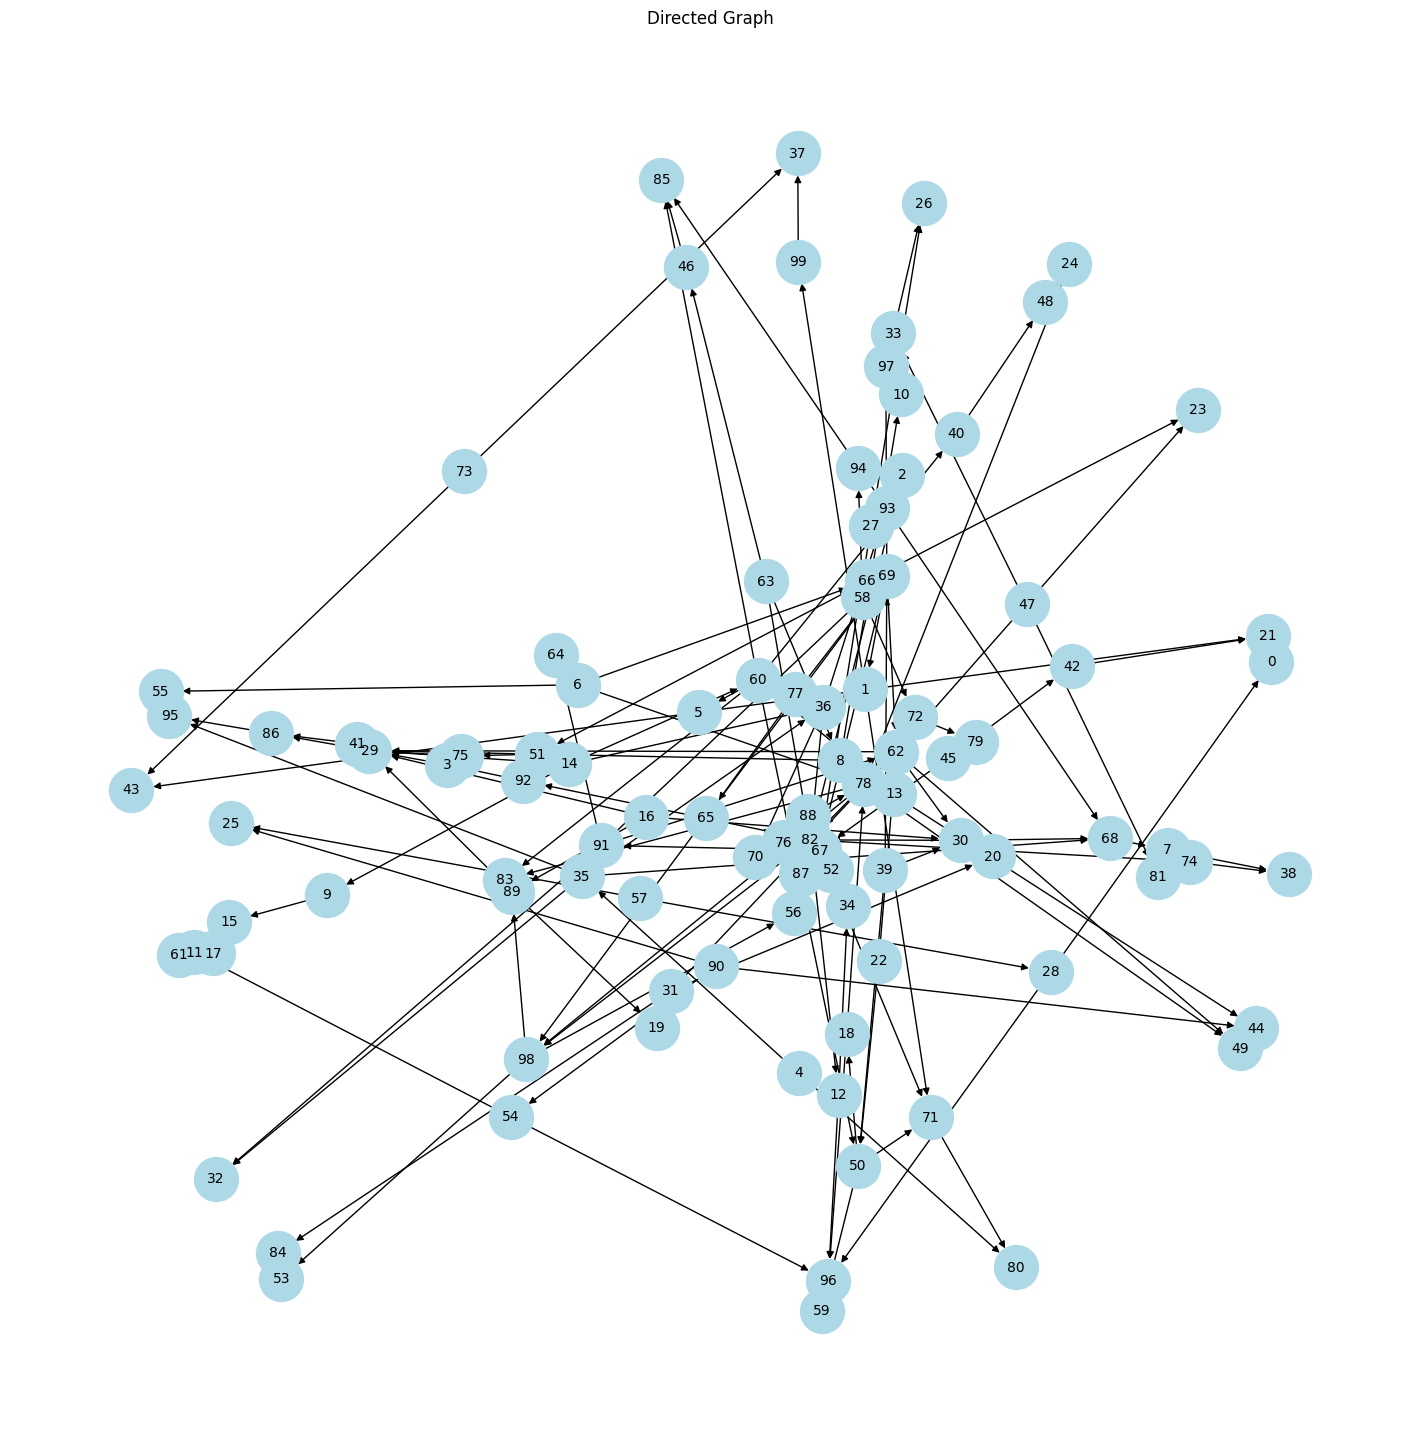

Correlation_coefficient: 0.5037746451106392


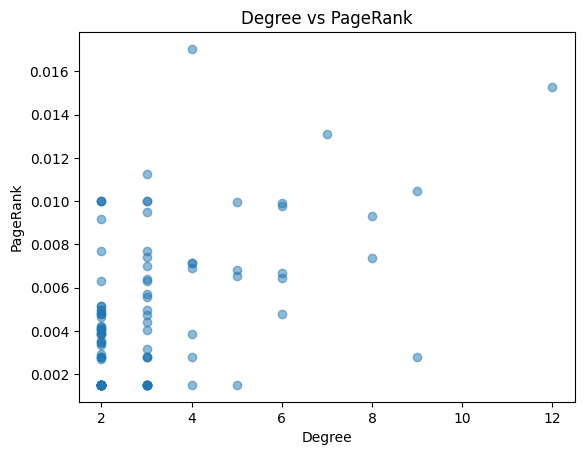

In [3]:
# 生成有向图
accessible_graph = generate_directed_graph(2, 20, 100)

# 计算PageRank
pagerank_values = calculate_pagerank(accessible_graph)

print("PageRank值:")
for node, pr in sorted(pagerank_values.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {pr}")

# 绘制有向图
draw_directed_graph(accessible_graph)

degrees =dict(accessible_graph.degree())
degree_values_list = np.array(list(degrees.values()))
pagerank_values_list = np.array(list(pagerank_values.values()))
correlation_coefficient = np.corrcoef(degree_values_list, pagerank_values_list)[0][1]

plt.scatter(degree_values_list, pagerank_values_list, alpha=0.5)
plt.title("Degree vs PageRank")
plt.xlabel("Degree")
plt.ylabel("PageRank")
print(f"Correlation_coefficient: {correlation_coefficient}")
plt.show()

设计Spam Farm

In [4]:
# 获取旧节点的所有邻接点（入边和出边）
in_edges = list(accessible_graph.in_edges(0))
out_edges = list(accessible_graph.out_edges(0))

# 保存旧节点的属性（如果有）
old_node_attributes = accessible_graph.nodes[0]

# 删除旧节点
accessible_graph.remove_node(0)

# 添加新节点，并将旧节点的属性复制到新节点上
accessible_graph.add_node('Target_page', **old_node_attributes)

# 将原有关联边重新指向新节点
for source, target in in_edges + out_edges:
    if source == 0:
        # 出边的情况，源节点是旧节点
        accessible_graph.add_edge('Target_page', target)
    elif target == 0:
        # 入边的情况，目标节点是旧节点
        accessible_graph.add_edge(source, 'Target_page')

graph_with_spam = spamming_graph(accessible_graph, Target_page='Target_page')

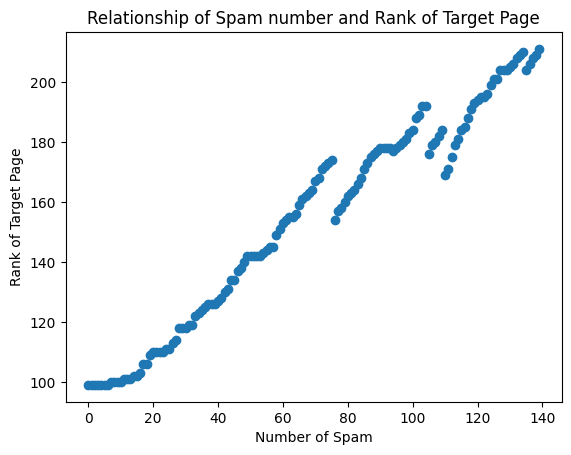

In [5]:
plot_relationship(accessible_graph, 10, 150, Target_page='Target_page')

In [6]:
accessible_list = []
spam_list = []
for node in list(graph_with_spam.nodes):
    if isinstance(node, int):
        accessible_list.append(node)
    elif node.startswith('Spam'):
        spam_list.append(node)

In [7]:
# 计算并打印TrustRank
Trustrank_values = calculate_trustrank(graph_with_spam, accessible_list)
print("TrustRank值:")
for node, pr in sorted(Trustrank_values.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {pr}")

[13, 37, 65, 92, 7]
TrustRank值:
Node 65: 0.03000283537852438
Node 13: 0.030000034166055095
Node 92: 0.030000000000000006
Node 7: 0.030000000000000006
Node 37: 0.030000000000000006
Node 82: 0.0036454806979262407
Node 60: 0.0031875000000000007
Node 68: 0.00255
Node 99: 0.001961538461538462
Node 73: 0.001961538461538462
Node 77: 0.0017030196726105925
Node 30: 0.0004923310329373932
Node 35: 0.00029418899565916863
Node 93: 0.0002709375
Node 62: 0.00026796421911261204
Node 36: 0.0002454219568850973
Node 63: 0.00022139353293739323
Node 52: 0.00022139353293739323
Node 87: 0.00022139353293739323
Node 76: 0.00022139353293739323
Node 14: 0.00019258743315916864
Node 1: 0.00013894230769230772
Node 39: 4.930959583816813e-05
Node 16: 4.6592899534209575e-05
Node 20: 4.6570686175218794e-05
Node 91: 4.138578262726502e-05
Node 69: 3.552124524862461e-05
Node 31: 2.514813339437436e-05
Node 56: 2.3604912572121134e-05
Node 2: 2.30296875e-05
Node 22: 2.0758625056316917e-05
Node 70: 1.8883930057696905e-05
Node

In [12]:
spam_pagerank = calculate_pagerank(graph_with_spam)

In [14]:
spam_mass = {}
for node, pr in spam_pagerank.items():
    if spam_pagerank[node] == 0:
        spam_mass[node] = 0
        continue
    spam_mass[node] = spam_pagerank[node] - Trustrank_values[node] / spam_pagerank[node]

In [15]:
print("Spam Mass值:")
for node, pr in sorted(spam_mass.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {pr}")

Spam Mass值:
Node Spam_Page_9: 0.050035274317276855
Node Spam_Page_4: 0.04939032613777562
Node Spam_Page_18: 0.04824313366851217
Node Spam_Page_15: 0.04802618644382297
Node Spam_Page_10: 0.047220430809542316
Node Spam_Page_1: 0.04703249243436923
Node Spam_Page_7: 0.046757097013555377
Node Spam_Page_8: 0.045401511339764
Node Spam_Page_2: 0.04384253581982321
Node Spam_Page_17: 0.04381203497715825
Node Spam_Page_6: 0.04337789862038294
Node Spam_Page_13: 0.04330137148536399
Node Spam_Page_22: 0.042536346744347746
Node Spam_Page_12: 0.04210268898299283
Node Spam_Page_14: 0.04116548573034595
Node Spam_Page_21: 0.040326263951723444
Node Spam_Page_11: 0.04012997742716398
Node Spam_Page_25: 0.040064639560263855
Node Spam_Page_23: 0.03981916131830035
Node Spam_Page_26: 0.0381791245111447
Node Spam_Page_3: 0.037968103776940675
Node Spam_Page_20: 0.03763461097285774
Node Spam_Page_27: 0.037558701667300985
Node Spam_Page_32: 0.0371080462036868
Node Spam_Page_19: 0.0361718888405401
Node Spam_Page_16: